<a href="https://colab.research.google.com/github/KimaniKibuthu/Swahili-News-Classification/blob/main/Swahili_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swahili News Classification
The objective of this hackathon is to develop a multi-class classification model to classify news content according to their specific categories specified.The model can be used by Swahili online news platforms to automatically group news according to their categories and help readers find the specific news they want to read. In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in the future.

The procedure will be:
1. Data Obtainance and Preparation.
2. Modelling and Evaluation.

# Libraries

In [1]:
!pip install tensorflow_text

In [57]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 19 kB/s 
     |████████████████████████████████| 6.8 MB 37.4 MB/s 
     |████████████████████████████████| 981 kB 39.8 MB/s 
     |████████████████████████████████| 263 kB 49.0 MB/s 
     |████████████████████████████████| 2.8 MB 40.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.9 MB/s 
     |████████████████████████████████| 285 kB 45.8 MB/s 
     |████████████████████████████████| 468 kB 38.3 MB/s 
     |████████████████████████████████| 596 kB 37.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.3 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 125 kB 51.4 MB/s 
     |████████████████████████████████| 243 kB 56.9 MB/s 
     |████████████████████████████████| 1.3 MB 34.6 MB/s 
     |████████████████████████████████| 271 kB 57.1 MB/s 
     |████████████████████████████████| 160 kB 47.9 MB/s 
  Created wheel f

In [1]:
# Libraries

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Dense

import ktrain
from ktrain import text
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data Obtainance and Preparation

## Data Obtainance

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
submission = pd.read_csv('/content/drive/MyDrive/Swahili News Project/SampleSubmission.csv')
test = pd.read_csv('/content/drive/MyDrive/Swahili News Project/Test.csv')
train = pd.read_csv('/content/drive/MyDrive/Swahili News Project/Train.csv')
variable_def = pd.read_csv('/content/drive/MyDrive/Swahili News Project/VariableDefinitions.csv')

In [4]:
# View data
train.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [5]:
# View test
test.head()

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


In [7]:
# View submission
submission.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,0,0


## Data Preparation

**View Distribution**

In [8]:
# View info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5151 non-null   object
 1   content   5151 non-null   object
 2   category  5151 non-null   object
dtypes: object(3)
memory usage: 120.9+ KB


In [9]:
# Check for nulls
train.isnull().sum()

id          0
content     0
category    0
dtype: int64

In [10]:
# Check for duplicates
train.duplicated().sum()

0

Kitaifa      0.388274
michezo      0.333916
Biashara     0.264026
Kimataifa    0.010483
Burudani     0.003300
Name: category, dtype: float64


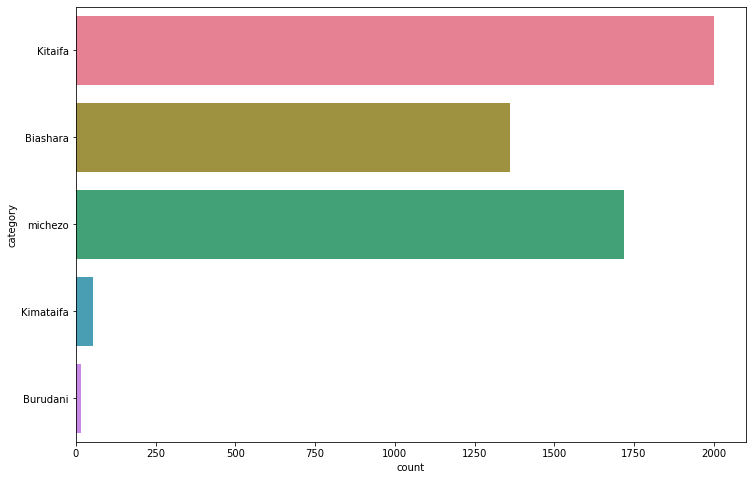

In [11]:
# Look at the distribution of the labels
print(train['category'].value_counts(normalize=True))

plt.figure(figsize=(12,8))
sns.countplot(y='category', data=train, palette='husl');

Kimataifa and Burudani seem to be imbalanced compared to the rest of the data

In [12]:
# Convert target to numerical
mapping = {
    'Kitaifa':0,
    'Biashara':1,
    'michezo':2,
    'Kimataifa':3,
    'Burudani':4
}


train['category'].replace(to_replace=mapping, inplace=True)

**Text Preprocessing**

In [13]:
# Get text and target values
texts = train['content'].values
target = train['category'].values

In [14]:
target_new = tf.keras.utils.to_categorical(target)

In [15]:
target.shape

(5151,)

In [16]:
# Observe texts
for i in range(1,10):
  print(f'{i}:{texts[i]}')

1: Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesitisha likizo za viongozi wote mkoani humo kutekeleza maazimio ya Jukwaa la Fursa za Biashara la mkoa huo.Mwanri ameagiza kuwa, hata kama kuna likizo zimeidhinishwa zifutwe.Amemuagiza Katibu Tawala wa Mkoa huo, Msalika Makungu kuandika barua kwa viongozi kuhusu uamuzi huo na amebainisha kuwa hakushauriwa na mtu, kaamua yeye.“Anayebisha anyooshe mkono, ajifanye angalau anajikuna tu” amesema Mwanri kwenye jukwaa hilo la nane lililomalizika leo.Amewaeleza viongozi wa Tabora kuwa, mambo waliyopanga kuyafanya wakati wa likizo nje ya Tabora wanaweza kuyafanya mkoani humo hivyo wawaite ndugu zao waende mkoani humo.Kiongozi huyo wa Tabora amewaagiza maofisa ugani mkoani humo watoke ofisini wahamie shambani.Viongozi mbalimbali wamehudhuria jukwaa la Tabora akiwemo mwenyekiti wa jukwaa hilo, Waziri wa Habari, Utamaduni, Sanaa na Michezo, Dk. Harrison Mwakyembe, Waziri wa Viwanda, Biashara na Uwekezaji Joseph Kakunda, Mwenyekiti wa Bodi ya Kampuni ya M

In [17]:
# Define Tokenizer

def tokenizer(texts):
  # tokenize text
  tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
  tokenizer.fit_on_texts(texts)
  #Get the word index
  word_index = tokenizer.word_index
  words = len(word_index) + 1

  # Create padded sequences
  sequences = tokenizer.texts_to_sequences(texts)
  seq_length = 50
  padded_sentences = pad_sequences(sequences, maxlen=seq_length, truncating='post')

  return padded_sentences, words, word_index

In [18]:
# Preprocess text

def preprocess_text(texts):
  new_texts = []
  for text in texts:
    # Make lower
    text = text.lower()

    # Remove url
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove placeholders
    text = re.sub(r"\[video\]", '', text)
    text = re.sub(r'{link}', '', text)

    # HTML and non letter characters
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)

    # Remove mentions
    text = re.sub('@[\w]+','', text)

    new_texts.append(text)

  # Tokenize texts
  
  padded_sentences, word_length, word_index = tokenizer(new_texts)

  return padded_sentences, word_length, word_index

In [19]:
# Text preprocessing
padded_sentences, word_length, word_index = preprocess_text(texts)

In [20]:
 # Observe Padded sentences
for i in range(1,10):
  print(f'{i}:{padded_sentences[i]}')

1:[  35    4   61    4  426 3177 2808    1 3101    7  166  124  131  498
  422 3233    2  635    9  116    7   71    9   61    1 2129   11  130
   24  121 3101    1    1  321  843    4   61   16    1 7798 1388  900
    5  166  150  506   16    3 3178   11]
2:[  17 1082  499  285    5  144  138    7  369  165    1  225    4 8901
    6 1059    4   42   45   26    3   19    2  293 2608  698    3    1
    1 5064    1 9621  422    1  235    4   15    4   81    4 1343    4
  225   16   49  154  156  360  321   35]
3:[  83    2   37    4 3460    2    1 3395  621    2 2234    3   23    2
  180    2  671    2 1493 1127    5   60  808  162  286    2   38  128
  958 2234   16   49   19    2 1756  264   16  415  414    4    1    1
 5615   10  123    2 3778  445   23   12]
4:[ 185    1 2809 1823    2 2933    5 6074  556  538    3  736 7800    7
   25   18  502    3  174   54 7801  188  544   21 4889    3  216    2
  390    7    1   29    4   87 3461    2 1823   12    2 2609 3534 6994
  740    4 204

In [21]:
padded_sentences.shape

(5151, 50)

# Modelling

In [22]:
# Get the embedding layer 
!wget --no-check-certificate \
    https://nlp.stanford.edu/data/glove.6B.zip \
    -o \content\drive\glove.zip

In [23]:
#Unzip the data
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [24]:
embeddings_index = {}
with open('/content/glove.6B.50d.txt', 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  
  f.close()

In [25]:
# Create embeddings matrix

embedding_matrix = np.zeros((word_length, 50))
for word , i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
# Build model
model = Sequential([
                        Embedding(word_length, 50, input_length=50, weights=[embedding_matrix], trainable=True),
                        Bidirectional(LSTM(10, return_sequences=True)),
                        Bidirectional(LSTM(10)),
                        Dense(16, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(5, activation='softmax')
])

adam = tf.keras.optimizers.Adam(0.001)
auc = tf.keras.metrics.AUC(name='auc')
model.compile(optimizer= adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', auc])

In [27]:
# Instantiate callbacks
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5)

  # reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

callbacks = [early_stopper, reduce_lr]

In [28]:
# Train model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

  
for train_index, test_index in skf.split(padded_sentences, target):
    x_train_fold, x_test_fold = padded_sentences[train_index], padded_sentences[test_index]
    y_train_fold, y_test_fold = target_new[train_index], target_new[test_index]
    history = model.fit(x=x_train_fold,
                        y=y_train_fold, 
                        batch_size=32,
                        epochs=10,
                        callbacks=callbacks,
                        validation_data=(x_test_fold, y_test_fold),
                        validation_batch_size=32)
    

Epoch 1/10
129/129 [==============================] - 17s 73ms/step - loss: 0.4818 - accuracy: 0.3658 - categorical_accuracy: 0.3658 - auc: 0.7411 - val_loss: 0.3937 - val_accuracy: 0.3919 - val_categorical_accuracy: 0.3919 - val_auc: 0.8014
Epoch 2/10
129/129 [==============================] - 8s 59ms/step - loss: 0.3456 - accuracy: 0.5362 - categorical_accuracy: 0.5362 - auc: 0.8646 - val_loss: 0.2580 - val_accuracy: 0.6712 - val_categorical_accuracy: 0.6712 - val_auc: 0.9289
Epoch 3/10
129/129 [==============================] - 8s 59ms/step - loss: 0.2410 - accuracy: 0.6837 - categorical_accuracy: 0.6837 - auc: 0.9341 - val_loss: 0.2554 - val_accuracy: 0.6673 - val_categorical_accuracy: 0.6673 - val_auc: 0.9245
Epoch 4/10
129/129 [==============================] - 8s 59ms/step - loss: 0.2175 - accuracy: 0.7303 - categorical_accuracy: 0.7303 - auc: 0.9491 - val_loss: 0.2374 - val_accuracy: 0.7420 - val_categorical_accuracy: 0.7420 - val_auc: 0.9388
Epoch 5/10
129/129 [===============

In [30]:
# Test
test_texts = test['content'].values

padded_test, _, _ = preprocess_text(test_texts)

In [31]:
# MAke predictions
predictions = model.predict(padded_test)

In [32]:
columns=['Kitaifa', 'Biashara', 'michezo', 'Kimataifa','Burudani']

In [33]:
# Create DF

df = pd.DataFrame(predictions, columns=columns)

df.head()

,Kitaifa,Biashara,michezo,Kimataifa,Burudani
0,0.281077,0.717583,0.000154,0.001099,0.000086
1,0.510805,0.006269,0.437460,0.036546,0.008920
2,0.999087,0.000780,0.000024,0.000097,0.000013
3,0.979157,0.001854,0.006930,0.011138,0.000922
4,0.004101,0.995708,0.000008,0.000162,0.000020


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Kitaifa    1288 non-null   float32
 1   Biashara   1288 non-null   float32
 2   michezo    1288 non-null   float32
 3   Kimataifa  1288 non-null   float32
 4   Burudani   1288 non-null   float32
dtypes: float32(5)
memory usage: 25.3 KB


In [35]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   swahili_id  1288 non-null   object
 1   kitaifa     1288 non-null   int64 
 2   michezo     1288 non-null   int64 
 3   biashara    1288 non-null   int64 
 4   kimataifa   1288 non-null   int64 
 5   burudani    1288 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 60.5+ KB


In [36]:
sub = submission[['swahili_id']]

final_sub = pd.concat([sub, df], axis=1)

final_sub.head()

,swahili_id,Kitaifa,Biashara,michezo,Kimataifa,Burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.281077,0.717583,0.000154,0.001099,0.000086
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.510805,0.006269,0.437460,0.036546,0.008920
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.999087,0.000780,0.000024,0.000097,0.000013
3,00868eeee349e286303706ef0ffd851f39708d37,0.979157,0.001854,0.006930,0.011138,0.000922
4,00a5cb12d3058dcf2e42f277eee599992db32412,0.004101,0.995708,0.000008,0.000162,0.000020


In [37]:
final_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   swahili_id  1288 non-null   object 
 1   Kitaifa     1288 non-null   float32
 2   Biashara    1288 non-null   float32
 3   michezo     1288 non-null   float32
 4   Kimataifa   1288 non-null   float32
 5   Burudani    1288 non-null   float32
dtypes: float32(5), object(1)
memory usage: 35.3+ KB


In [38]:
final_sub.to_csv('sub.csv', index=False)

## BERT Model

In [40]:
# Train
x = train['content']
y = train['category']

## BERT Model

In [6]:
# train
train.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [7]:
def bert_preprocess_text(df):
  texts = df['content']
  new_texts = []
  for text in texts:
    # Make lower
    text = text.lower()

    # Remove url
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove placeholders
    text = re.sub(r"\[video\]", '', text)
    text = re.sub(r'{link}', '', text)

    # HTML and non letter characters
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)

    # Remove mentions
    text = re.sub('@[\w]+','', text)

    new_texts.append(text)

  # Tokenize texts
  
  df['content'] = new_texts

  return df

In [8]:
# Clean texts in train
new_train = bert_preprocess_text(train)


In [9]:
new_train.head()

,id,content,category
0,SW0,serikali imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,mkuu wa mkoa wa tabora aggrey mwanri amesitis...,Biashara
2,SW10,serikali imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,kampuni ya mchezo wa kubahatisha ya mbet imei...,michezo
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [16]:
# Split data
x = new_train['content'].to_numpy()
y = new_train['category'].to_numpy()


x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.9,
                                                    random_state=42,
                                                    stratify=y)

In [12]:
names = list(train['category'].unique())

names

['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani']

In [19]:
# Make data ready for bert model
(x_train_bert, y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(
    x_train = x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    class_names = names,
    preprocess_mode='bert',
    maxlen=100,
    max_features=50000
)

preprocessing train...
language: sw


Is Multi-Label? False
preprocessing test...
language: sw


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


task: text classification


In [20]:
# Create model
model = text.text_classifier('bert',
                             train_data=(x_train_bert, y_train_bert),
                             preproc=preproc)

learner = ktrain.get_learner(model,
                             train_data=(x_train_bert, y_train_bert),
                             val_data=(x_val_bert, y_val_bert))


Is Multi-Label? False
maxlen is 100
done.


In [21]:
# Find best learning rate
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/1024
145/145 [==============================] - 214s 1s/step - loss: 1.6003 - accuracy: 0.2205
Epoch 2/1024
145/145 [==============================] - 190s 1s/step - loss: 1.1418 - accuracy: 0.5510
Epoch 3/1024
145/145 [==============================] - 188s 1s/step - loss: 0.6234 - accuracy: 0.7689
Epoch 4/1024
145/145 [==============================] - 188s 1s/step - loss: 0.4715 - accuracy: 0.8300
Epoch 5/1024
145/145 [==============================] - 190s 1s/step - loss: 0.4516 - accuracy: 0.8410
Epoch 6/1024
145/145 [==============================] - 190s 1s/step - loss: 0.7238 - accuracy: 0.7126
Epoch 7/1024
145/145 [==============================] - 188s 1s/step - loss: 1.2432 - accuracy: 0.3696
Epoch 8/1024
145/145 [==============================] - 187s 1s/step - loss: 1.6367 - accuracy: 0.3461
Epoch 9/1024
145/145 [==============================] - 28s 188ms/step - loss: 2.2166 - accuracy: 0.3068


done.
Please invoke the Learner.lr_plot() method to visually inspect 

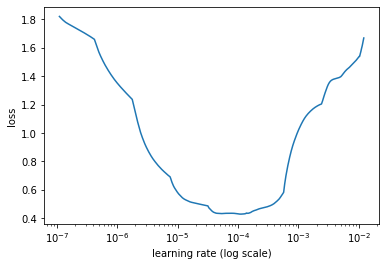

In [22]:
learner.lr_plot()

In [23]:
learner.autofit(1e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
145/145 [==============================] - 224s 1s/step - loss: 0.7853 - accuracy: 0.6712 - val_loss: 0.4820 - val_accuracy: 0.8450
Epoch 2/1024
145/145 [==============================] - 196s 1s/step - loss: 0.4763 - accuracy: 0.8276 - val_loss: 0.4536 - val_accuracy: 0.8430
Epoch 3/1024
145/145 [==============================] - 196s 1s/step - loss: 0.4041 - accuracy: 0.8539 - val_loss: 0.4375 - val_accuracy: 0.8372
Epoch 4/1024
145/145 [==============================] - 196s 1s/step - loss: 0.3589 - accuracy: 0.8706 - val_loss: 0.4035 - val_accuracy: 0.8643
Epoch 5/1024
145/145 [==============================] - 196s 1s/step - loss: 0.3148 - accuracy: 0.8826 - val_loss: 0.4152 - val_accuracy: 0.8469
Epoch 6/1024
145/145 [==============================] - 196s 1s/step - loss: 0.2912 - accu

In [24]:
# Predict

# GEt predictor
predictor = ktrain.get_predictor(learner.model, preproc)

In [25]:
# Make test
new_test = bert_preprocess_text(test)

In [26]:
# GEt predictions
preds = predictor.predict(new_test['content'].to_numpy(), return_proba=True)

In [27]:
preds

array([[1.7271407e-02, 2.8311901e-04, 2.2723589e-03, 9.7666842e-01,
        3.5047275e-03],
       [1.1857701e-03, 1.9194507e-03, 8.3148881e-04, 2.2962786e-02,
        9.7310048e-01],
       [6.3875794e-01, 1.0388780e-03, 3.1494182e-03, 3.5293886e-01,
        4.1148984e-03],
       ...,
       [1.3930105e-03, 2.2052089e-03, 9.8635769e-04, 2.2696584e-02,
        9.7271889e-01],
       [1.5649616e-03, 1.8122735e-03, 7.7035645e-04, 2.1188695e-02,
        9.7466373e-01],
       [2.4308918e-02, 2.4990120e-04, 1.1976465e-03, 9.6767241e-01,
        6.5710847e-03]], dtype=float32)

In [29]:
predictor.get_classes()

['Biashara', 'Burudani', 'Kimataifa', 'Kitaifa', 'michezo']

In [30]:
# Create submission file
sub = pd.DataFrame(preds, columns = predictor.get_classes())

In [31]:
sub.head()

,Biashara,Burudani,Kimataifa,Kitaifa,michezo
0,0.017271,0.000283,0.002272,0.976668,0.003505
1,0.001186,0.001919,0.000831,0.022963,0.973100
2,0.638758,0.001039,0.003149,0.352939,0.004115
3,0.011510,0.000884,0.010062,0.968256,0.009287
4,0.345723,0.000493,0.002054,0.649202,0.002528


In [32]:
submission

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0,0,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0,0,0,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,0,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,0,0,0,0,0
...,...,...,...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,0,0,0,0,0
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,0,0,0,0,0
1285,feed09e13586d12139cd59bc20996a4d29706606,0,0,0,0,0
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,0,0,0,0,0


In [33]:
submission['kitaifa'] = sub['Kitaifa']
submission['michezo'] = sub['michezo']
submission['biashara'] = sub['Biashara']
submission['kimataifa'] = sub['Kimataifa']
submission['burudani'] = sub['Burudani']

In [34]:
submission.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.976668,0.003505,0.017271,0.002272,0.000283
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.022963,0.973100,0.001186,0.000831,0.001919
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.352939,0.004115,0.638758,0.003149,0.001039
3,00868eeee349e286303706ef0ffd851f39708d37,0.968256,0.009287,0.011510,0.010062,0.000884
4,00a5cb12d3058dcf2e42f277eee599992db32412,0.649202,0.002528,0.345723,0.002054,0.000493


In [36]:
# Save to CSV
submission.to_csv('submission.csv', index=False)

The model obtains a logloss score of **0.362503845218691** On the competition earning me position 11.